<a href="https://colab.research.google.com/github/bobothebest/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# The Main Data Loading Pipeline Summarized

The complete chapter code is located in [ch02.ipynb](./ch02.ipynb).

This notebook contains the main takeaway, the data loading pipeline without the intermediate steps.

Packages that are being used in this notebook:

In [1]:
# NBVAL_SKIP
!pip install tiktoken
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.2 MB/s eta 0:00:00
torch version: 2.6.0+cu124
tiktoken version: 0.9.0


In [2]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

## A.6 Setting up efficient data loaders

PyTorch 中数据加载的总体思想在下图中进行了说明。

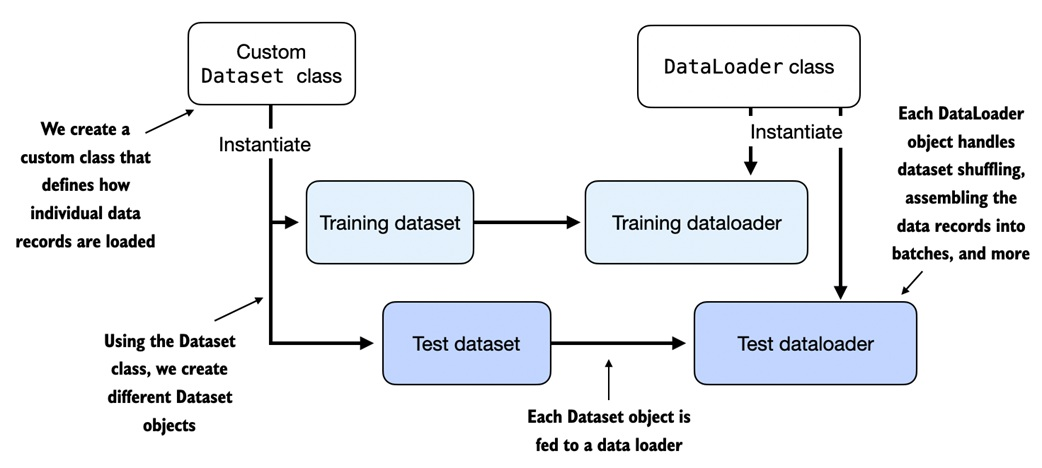

### 左侧：Dataset 类部分

1. **自定义 Dataset 类**：首先，我们创建一个自定义的 Dataset 类，这个类定义了如何加载单个数据记录。这是整个数据加载流程的起点。

2. **Dataset 类的实例化**：使用这个自定义的 Dataset 类，我们可以创建不同的 Dataset 对象，通常分为两类：
   - 训练数据集（Training dataset）
   - 测试数据集（Test dataset）

### 右侧：DataLoader 类部分

1. **DataLoader 类**：这是 PyTorch 提供的标准工具类，用于高效地管理数据加载过程。

2. **DataLoader 的实例化**：Dataset 对象被传递给 DataLoader 进行实例化，创建对应的：
   - 训练数据加载器（Training dataloader）
   - 测试数据加载器（Test dataloader）

3. **DataLoader 的功能**：每个 DataLoader 对象负责处理以下任务：
   - 数据集的随机打乱（shuffling）
   - 将单个数据记录组装成批次（batches）
   - 多线程加载
   - 其他数据预处理和管理任务

### 数据流向

整个流程的数据流向是：
1. 自定义 Dataset 类 → 创建 Dataset 对象（训练集和测试集）
2. 每个 Dataset 对象被传入到相应的 DataLoader
3. DataLoader 处理批处理、随机化等操作，为模型训练准备数据


下面我们按照上图流程实现 PyTorch 的数据加载。  
首先创建一个自定义 Dataset 类，用它来生成训练集和测试集，然后创建相应的数据加载器。  
我们将从构建一个简单的玩具数据集开始，包含5个训练样本（每个有2个特征），对应的类别标签（3个属于类别0，2个属于类别1），以及2个测试样本。


In [4]:
import torch
# 创建一个小的玩具数据集
X_train = torch.tensor([
[-1.2, 3.1],
[-0.9, 2.9],
[-0.5, 2.6],
[2.3, -1.1],
[2.7, -1.5]
])

y_train = torch.tensor([0, 0, 0, 1, 1])

X_test = torch.tensor([
[-0.8, 2.8],
[2.6, -1.6],
])

y_test = torch.tensor([0, 1])

In [9]:
import tiktoken
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

vocab_size = 50257
output_dim = 256
context_length = 1024


token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

batch_size = 8
max_length = 4
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length
)

In [10]:
for batch in dataloader:
    x, y = batch

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break

In [ ]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])
